In [3]:
import numpy as np
import matplotlib as mpl   
import matplotlib.pyplot as plt
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import autograd.numpy as np
from autograd import grad, elementwise_grad    
from autograd.misc.flatten import flatten

(64, 64)


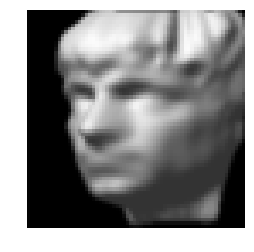

In [15]:
face_img = ia.load_image_gray('new_data/face_0000.png') / 65535.0
print(face_img.shape)
ia.show_image_mpl(face_img)

In [16]:
#load the data
#input data
image_data= ia.load_image_gray('new_data/face_strip.png')/65535.0
faces_data=image_data.reshape(64,698,64)
faces=np.einsum("ijk->jik",faces_data)
faces=faces[:,::2,::2]#every second row and column element
face_inputs=faces.reshape(698,1024)
#expected outputs:face pose(4 directions)
new_data=np.loadtxt('new_data/face_pose_degrees.txt ')
face_poses=new_data.swapaxes(0,1)
expected_face_orientations=face_poses/180.0

In [17]:
# hill climbing search
def predict(x,theta,unflatten):
    for w in unflatten(theta):
        x=w.T@np.tanh(x+0.1)
    return x

def face_loss(theta, unflatten, x, y):
    y_prime = predict(x,theta,unflatten)
    L2=np.linalg.norm((y_prime-y),ord=2) 
    return(L2)

def total_face_loss(theta, unflatten):
    totalloss=np.zeros(expected_face_orientations[:,0].shape)
    for i in range(len(totalloss)):
        totalloss[i]=face_loss(theta,unflatten,face_inputs[i,:],expected_face_orientations[i,:])
    #print(total)
    total=np.sum(totalloss,axis=0)
    return total

def initial_conditions(shape_list,sigma): 
    matrices=[]#(shape_list)
    for i in range(len(shape_list)):
        x=np.random.normal(0,sigma,(shape_list[i]))   
        matrices.append(x)
        theta,unflatten=flatten(matrices)
    return theta,unflatten
    
    

Text(0.5,1,'True face orientations')

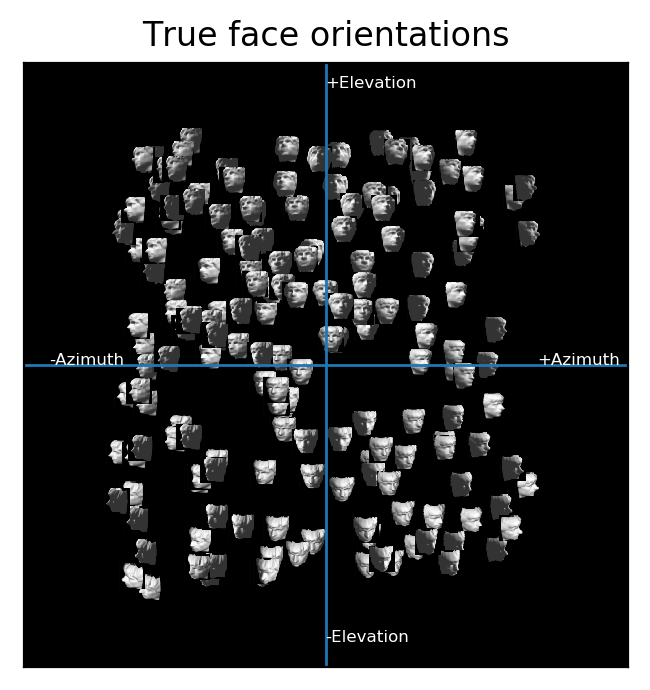

In [18]:
def show_faces(images, positions):
    # show the faces, and their orientations
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor('k')
    sz = 0.025
    for i in range(0,len(positions),4):
        pos = positions[i]
        
        # show the image at the output position
        ax.imshow(images[i].reshape(faces.shape[1],faces.shape[2]), 
                  extent=[pos[0]-sz, pos[0]+sz, -pos[1]*8-sz, -pos[1]*8+sz],
                  vmin=0, vmax=1, cmap='gray')
        
    ax.axhline(0, lw=1)
    ax.axvline(0, lw=1)
    ax.text(0,0.55, '+Elevation', color='w', fontdict={"fontsize":6})
    ax.text(0,-0.55, '-Elevation', color='w', fontdict={"fontsize":6})
    ax.text(0.42,0.0, '+Azimuth', color='w', fontdict={"fontsize":6})
    ax.text(-0.55,0.0, '-Azimuth', color='w', fontdict={"fontsize":6})
    ax.set_xlim(-0.6,0.6)
    ax.set_ylim(-0.6,0.6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Face orientations")
    
# apply to the *known* inputs and outputs
show_faces(face_inputs, expected_face_orientations)
plt.gca().set_title("True face orientations")

In [27]:
face_guess=initial_conditions

def hill_climbing(l, max_iters, guess_fn, neighbour_fn):
    guess,unflatten = initial_conditions( [[1024,32], [32, 16],  [16, 8], [8,2]], 0.2)
     
    best_loss=None
    best_guess=None
    #for each iteration, adjust the current best guess a little 
    #to get a neighbour value
    for i in range(max_iters):        
        if best_loss is None or l(guess,unflatten)<best_loss:
            best_loss = l(guess,unflatten)
            best_guess=guess
        guess = neighbour_fn(best_guess)         
    return best_guess,unflatten

def face_neighbour(x):
    # adjust the guess a bit
    return np.random.normal(0,0.01,x.shape) + x

In [ ]:
np.random.seed(2018)

# you will need to define face_guess and face_neighbour
result,  unflatten = hill_climbing(total_face_loss, 250, face_guess, face_neighbour)

print("Loss in prediction {loss}".format(loss=total_face_loss(result, unflatten)))
    
# predict the outputs 
predicted_outputs = [predict(face_inputs[i], result, unflatten) for i in range(698)]
show_faces(face_inputs, np.array(predicted_outputs))
plt.gca().set_title("Hill climbed face orientation predictions")

loss no.0.000000 is 12994.230902S
loss no.0.000000 is 148.561795S
loss no.1000.000000 is 39.755076S
loss no.2000.000000 is 27.630947S
loss no.3000.000000 is 32.657757S
loss no.4000.000000 is 20.881959S
loss no.5000.000000 is 25.517118S
loss no.6000.000000 is 15.014156S
loss no.7000.000000 is 16.995898S
loss no.8000.000000 is 18.898142S
loss no.9000.000000 is 20.290124S
loss no.10000.000000 is 18.232311S
loss no.11000.000000 is 17.794404S
loss no.12000.000000 is 15.891650S
loss no.13000.000000 is 19.912467S
loss no.14000.000000 is 12.142823S
loss no.15000.000000 is 20.934413S
loss no.16000.000000 is 11.378911S
loss no.17000.000000 is 17.418867S
loss no.18000.000000 is 12.531414S
loss no.19000.000000 is 18.884405S


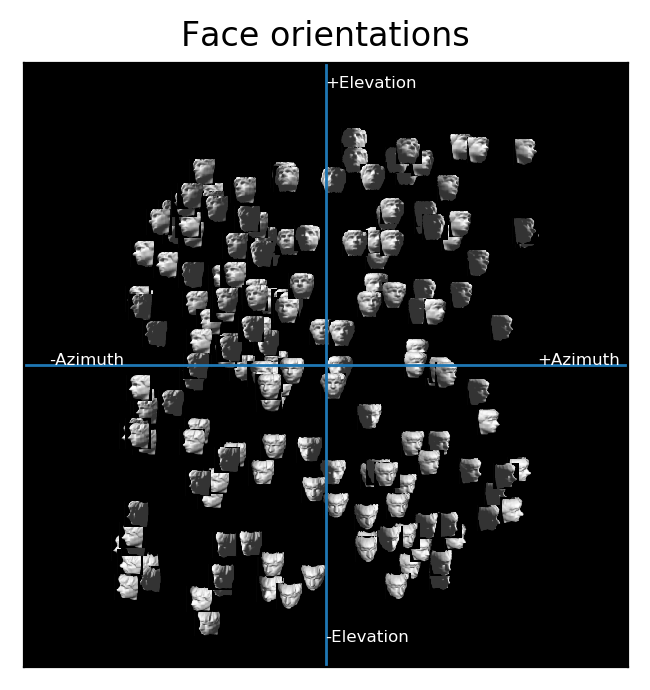

In [26]:
#Gradient descent learning
def grad_face_loss(theta,unflatten,x,y):
    grad_face_loss = grad(face_loss)
    return grad_face_loss(theta,unflatten,x,y)
def sgd_learn(shapes, inputs, outputs, sigma=0.1, step=0.1, iters=10000):
    w,unflatten=initial_conditions(shapes,sigma)
    for i in range(iters):
        ix=np.random.randint(0,698,size=(1,))
        x=np.squeeze(inputs[ix,:])
        y=np.squeeze(outputs[ix,:])
        w-=step*grad_face_loss(w,unflatten,x,y)
        if i%1000==0:
            print('loss no.%f is %fS' % (i,total_face_loss(w,unflatten)))        
    return w, unflatten

test_theta, test_unflatten = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.1, 0.1, 1)
np.random.seed(2018)

theta,unflatten=sgd_learn([[1024,32], [32, 16],  [16, 8], [8,2]],face_inputs,expected_face_orientations,0.1,0.04,20000)
predicted_outputs = [predict(face_inputs[i], theta, unflatten) for i in range(698)]
show_faces(face_inputs, np.array(predicted_outputs))